In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import fetchyc
import collections
import kerastuner as kt
from tensorflow.keras.optimizers import Adam

#!pip install -q requests
import requests
import json

In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\

In [115]:
#!pip install -q -U keras-tuner

In [3]:
dataset = tf.data.experimental.make_csv_dataset('./EU_France_9480.csv',batch_size = 360, shuffle = False)
rr = None
for it in dataset.map(lambda x: fetchyc.mapelement(x)):
    d = it['Date'].numpy()
    if d > b'2010-01-01':
        rr = it
        break

Cause: could not parse the source code:

for it in dataset.map(lambda x: fetchyc.mapelement(x)):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

for it in dataset.map(lambda x: fetchyc.mapelement(x)):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("concat_18:0", shape=(2, 6841), dtype=float32)


In [4]:
rr

{'Date': <tf.Tensor: shape=(), dtype=string, numpy=b'2010-02-24'>,
 'XY': <tf.Tensor: shape=(2, 6457), dtype=float32, numpy=
 array([[  0.75 ,   0.75 ,   0.76 , ...,   3.314,   3.247,   3.312],
        [  1.   ,   1.   ,   1.   , ..., 600.   , 600.   , 600.   ]],
       dtype=float32)>}

# 1.Fetch and combine all available data into single data frame table

In [5]:
class NelsonSiegelLayer(tf.keras.layers.Layer):
    def __init__(self, thau0 = 64.0, eps = 0.00001):
        super(NelsonSiegelLayer, self).__init__()
        self.eps = eps
        self.thau = self.add_weight(name = "Thau", shape = (), 
                                     initializer = tf.keras.initializers.Constant(thau0),
                                     #constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha0 = self.add_weight(name = "Alpha0", shape = (), 
                                     initializer = tf.keras.initializers.RandomUniform(0.0, 1.0),
                                     constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha1 = self.add_weight(name = "Alpha1", shape = (), 
                                     initializer = tf.keras.initializers.RandomUniform(0.0, 1.0),
                                     constraint = tf.keras.constraints.NonNeg(),
                                     trainable = True)
        self.alpha2 = self.add_weight(name = "Alpha2", shape = (), 
                                     initializer = "random_normal",                           
                                     trainable = True)
        #self.bias = self.add_weight(name = "Bias", shape = (), trainable = True)
        
    def call(self, inputs):
        val1 = tf.divide(inputs, self.thau)
        val2 = tf.math.exp(-val1)
        val3 = tf.divide(1.0 - val2, val1)
        eps = self.eps
        return tf.add(tf.math.multiply(self.alpha0 + eps, 1.0 - val3), 
                                       tf.add(tf.math.multiply(self.alpha1 + eps, val3),
                                        tf.math.multiply(self.alpha2, val3 - val2)))

In [6]:
NSL = NelsonSiegelLayer(thau0 = 64)
inputs = tf.keras.Input(shape = ())
outputs = NSL(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.1), loss="mse")
hist = model.fit(rr['XY'][1], rr['XY'][0], epochs = 256, verbose = 0)
print(model.evaluate(rr['XY'][1], rr['XY'][0], verbose = 0))
print(NSL.thau)

0.1102718934416771
<tf.Variable 'Thau:0' shape=() dtype=float32, numpy=96.496765>


In [10]:
model.predict(np.array([360.0]))

array([4.0608387], dtype=float32)

In [13]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = "./models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = ./models\1

INFO:tensorflow:Assets written to: ./models\1\assets

Saved model:


In [16]:
mm = tf.keras.models.load_model(export_path)

In [17]:
mm.predict(np.array([360.0]))

array([4.0608387], dtype=float32)

In [ ]:
!saved_model_cli show --dir {export_path} --all

In [42]:
!docker run -p 8511:8511 \
  --mount type=bind,source="C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\models",target="\\models\\my_model" \
  -e MODEL_NAME=my_model -t tensorflow/serving

^C


In [22]:
"C:\\Users\\PLDD\\Practice\\GitHub\\Python\\MHS\\models"

'./models'

In [31]:
!docker run --help


Usage:	docker run [OPTIONS] IMAGE [COMMAND] [ARG...]

Run a command in a new container

Options:
      --add-host list                  Add a custom host-to-IP mapping
                                       (host:ip)
  -a, --attach list                    Attach to STDIN, STDOUT or STDERR
      --blkio-weight uint16            Block IO (relative weight),
                                       between 10 and 1000, or 0 to
                                       disable (default 0)
      --blkio-weight-device list       Block IO weight (relative device
                                       weight) (default [])
      --cap-add list                   Add Linux capabilities
      --cap-drop list                  Drop Linux capabilities
      --cgroup-parent string           Optional parent cgroup for the
                                       container
      --cidfile string                 Write the container ID to the file
      --cpu-period int                 Limit CPU CFS (Completely 

      --stop-signal string             Signal to stop a container
                                       (default "15")
      --stop-timeout int               Timeout (in seconds) to stop a
                                       container
      --storage-opt list               Storage driver options for the
                                       container
      --sysctl map                     Sysctl options (default map[])
      --tmpfs list                     Mount a tmpfs directory
  -t, --tty                            Allocate a pseudo-TTY
      --ulimit ulimit                  Ulimit options (default [])
  -u, --user string                    Username or UID (format:
                                       <name|uid>[:<group|gid>])
      --userns string                  User namespace to use
      --uts string                     UTS namespace to use
  -v, --volume list                    Bind mount a volume
      --volume-driver string           Optional volume driver for the
  

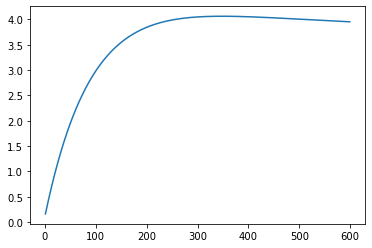

In [49]:
time_seq = np.arange(600)
data = json.dumps({"signature_name": "serving_default", "instances": time_seq.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
y = json.loads(json_response.text)['predictions']
plt.plot(x,y)

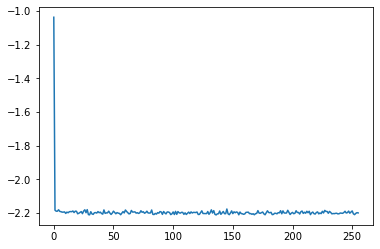

In [7]:
plt.plot(hist.epoch, np.log(hist.history['loss']))

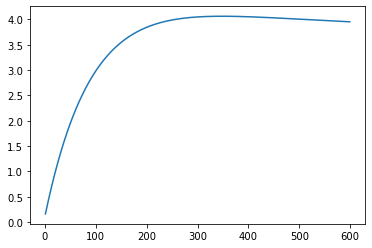

In [8]:
time_seq = np.arange(600)
x = time_seq[:600]
y = model.predict(x)
plt.plot(x,y)

In [63]:
rr['XY']

<tf.Tensor: shape=(2, 70), dtype=float32, numpy=
array([[ 10.62 ,  10.82 ,  10.77 ,  10.9  ,  10.92 ,  10.92 ,  11.5  ,
         11.24 ,  11.25 ,  11.19 ,  11.2  ,  11.14 ,  11.12 ,  11.08 ,
         10.15 ,  10.27 ,  10.45 ,  10.34 ,  10.34 ,  10.34 ,  10.67 ,
         10.67 ,  10.58 ,  10.6  ,  10.63 ,  10.56 ,  10.45 ,  10.36 ,
         10.057,  10.128,  10.238,  10.371,  10.288,  10.288,  10.489,
         10.66 ,  10.553,  10.559,  10.549,  10.483,  10.483,  10.306,
          9.77 ,   9.89 ,  10.03 ,   9.98 ,  10.   ,  10.   ,  10.21 ,
         10.25 ,  10.22 ,  10.25 ,  10.29 ,  10.24 ,  10.23 ,  10.14 ,
          9.118,   9.215,   9.289,   9.38 ,   9.348,   9.348,   9.486,
          9.539,   9.524,   9.568,   9.609,   9.555,   9.491,   9.441],
       [  3.   ,   3.   ,   3.   ,   3.   ,   3.   ,   3.   ,   3.   ,
          3.   ,   3.   ,   3.   ,   3.   ,   3.   ,   3.   ,   3.   ,
         24.   ,  24.   ,  24.   ,  24.   ,  24.   ,  24.   ,  24.   ,
         24.   ,  24.   ,  

In [189]:
tunning_epoch_cnt = 256
def model_builder(hp): 
    
    inputs = tf.keras.Input(shape = ())
    hp_thau = hp.Float('thau0',min_value = 1.0, max_value = 120.0, default=64.0,
                    step=10.0)
    outputs = NelsonSiegelLayer(thau0 = hp_thau)(inputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

tuner = kt.Hyperband(model_builder,
                     objective = 'loss', 
                     max_epochs = tunning_epoch_cnt,
                     factor = 2,
                     directory = 'keras_tuning', # throw exception when either capital letters or numbers are in name of directory
                     project_name = 'some') # throw exception when either capital letters or numbers are in name of directory

tuner.search(rr['XY'][1], rr['XY'][0], epochs = tunning_epoch_cnt, verbose = 0)
tuner.results_summary()

In [234]:
thauV = np.arange(1.0, 120.0, 10.)
realV = []
lossV = []

In [ ]:
for thau in thauV:
    NSL = NelsonSiegelLayer(thau0 = thau)
    inputs = tf.keras.Input(shape = ())
    outputs = NSL(inputs)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    model.fit(rr['XY'][1], rr['XY'][0], epochs = 1024, verbose = 0)
    lossV.append(model.evaluate(rr['XY'][1], rr['XY'][0], verbose = 0))
    realV.append(NSL.thau)

In [ ]:
srcdir = r'.\data\raw\YC'
destdir = './'
fetchyc.FirstConversion()

In [ ]:
def mapelement(table):
    valpairs = None
    for key, x in TermMapToMonth.items():
        if key in not table:
            continue
        xy = table[key][table[key] > 256.0]
        if table[key].dtype == tf.string:
            print(table[key])
            #xy = tf.strings.to_number(table[key][table[key] != b''], out_type=tf.dtypes.float32)
            xy = tf.strings.to_number(table[key], out_type=tf.dtypes.float32)
            print(xy)
            print(table[key])
        if xy.shape[0] is not None:
            xy = tf.stack([xy, tf.repeat(x,xy.shape[0])])
            if valpairs is None:
                valpairs = xy
            else:
                valpairs = tf.concat([valpairs,xy], axis = 1)       
    m = table['Date'].shape[0] // 2
    return {'Date' : table['Date'][m], 'XY' : valpairs}

@tf.function
def mapelement1(table):
    obss = tf.convert_to_tensor(np.array([[-256.0], [-256.0]]), dtype = tf.float32)
    tt = 'M01'
    x = TermMapToMonth[tt]
    xy = tf.convert_to_tensor(table[tt])
    print(xy)
    lx = xy > -255.0
    xy = tf.boolean_mask(xy, lx)
    #print(xy)
    #print(xy.numpy())
    xy = tf.stack([xy, tf.repeat(x,xy.shape[0])])
    obss = tf.concat([obss,xy], axis = 1) 
    print(obss)
    lx = obss[0] > -255.0
    print(lx)
    obss = tf.boolean_mask(obss, lx, axis = 1)
    median = table['Date'].shape[0] // 2
    return {'Date' : table['Date'][median], 'XY' : xy}

In [ ]:
t = np.linspace(6.5, 20.0, 5)
#t = [6.8]
b0 = 5
b1 = -1
b2 = 3
b0, b1, b2 = (0.0466, -0.0429, 0.0712)
for x in np.linspace(0.0, 100.0, 10):
    b0 = np.linspace(0.0, 100.0, 1000)
    m = 6.5
    y = np.exp(b0) + ((b1 + b2) * (1.0 - np.exp(-x/m))/(x/m)) - b2 * np.exp(-x/m)
    plt.plot(b0, y)
plt.show()

In [ ]:
    
b0 = np.linspace(-100, 100.0, 100)
b2 = 3.14
for b1 in np.linspace(0.0, 17.5, 10):
    y = (np.exp(b0) + np.exp(b1 - b0) - b2)**2
    plt.plot(b0, y)
plt.show()